##### **Load all the libraries**

In [1]:
#basic
import numpy as np
import pandas as pd
from datetime import datetime

#vis

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#text
import re
import string
import nltk.stem as stemmer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

#ML
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

#ML metrics
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score

C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I347687\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Import data sets
#Change paths!
fake_news = pd.read_csv("C:/Users/I347687/Desktop/challenge/archive/Fake.csv")
real_news = pd.read_csv("C:/Users/I347687/Desktop/challenge/archive/True.csv")

In [3]:
fake_news.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [4]:
real_news.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


##### **Create target variable and concatenate data sets**

In [5]:
real_news['Is_Fake'] = 0
fake_news['Is_Fake'] = 1
news = pd.concat([real_news, fake_news])

In [6]:
news.head()

,title,text,subject,date,Is_Fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


### **Exploratory data analysis**

In [7]:
#Is there any null values?
news.isnull().sum()

title      0
text       0
subject    0
date       0
Is_Fake    0
dtype: int64

In [8]:
#Is there any duplicates?
news.duplicated().sum()

209

In [9]:
#Is our data set balanced?
news['Is_Fake'].value_counts()

1    23481
0    21417
Name: Is_Fake, dtype: int64

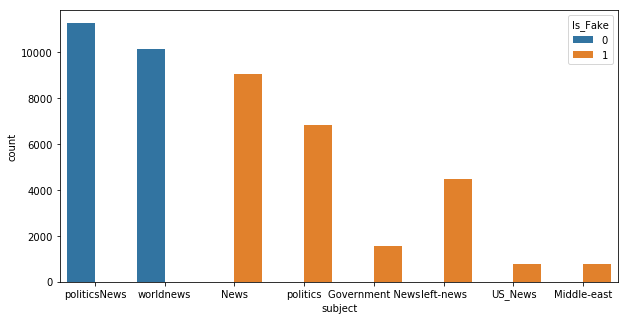

In [10]:
#Let's analyze the distribution of subject along fake and real news
plt.figure(figsize=(10,5))
sns.countplot(x= "subject", hue = "Is_Fake", data=news)

##### **As we can see, the subject of real news is more related to politics and world news. However, fake news have a bigger variety of subjects: Government, US, Middle-East, left, etc.**

##### **Let us also analyze the date and check if there is any correlation between date (month, quarter, etc.) and news being false or not. Before that, we need to transform and cast date field**

In [11]:
news.dtypes

title      object
text       object
subject    object
date       object
Is_Fake     int64
dtype: object

In [12]:
#Trim field
news['date'] = news['date'].str.strip()

In [13]:
###Replace some of the values so that the whole field is consistent and we can convert it into date format
news['date'] = np.where(news['date'] == '19-Feb-18',
                                           'February 19, 2018',
                                           np.where(news['date'] == '18-Feb-18',
                                                    'February 18, 2018',
                                                        np.where(news['date'] == '17-Feb-18',
                                                            'February 17, 2018',
                                                                 np.where(news['date'] == '16-Feb-18',
                                                                    'February 16, 2018',
                                                                            np.where(news['date'] == '15-Feb-18',
                                                                                'February 15, 2018',
                                                                                       np.where(news['date'] == '14-Feb-18',
                                                                                            'February 14, 2018', news['date']))))))

In [14]:
#As we can see, we dates, which are links. We should these observations from our data set
news[news['date'].str.contains("https")]

,title,text,subject,date,Is_Fake
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1


##### **In the next steps, all strange observations are removed**

In [15]:
news = news[~news.date.str.contains("https")]

In [16]:
news[news['date'].str.contains("MSNBC")]

,title,text,subject,date,Is_Fake
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,1


In [17]:
news = news[~news.date.str.contains("MSNBC")]

In [18]:
###
news['Date_mod'] = pd.to_datetime(news['date'], infer_datetime_format=True)

In [19]:
news.head(3)

,title,text,subject,date,Is_Fake,Date_mod
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,2017-12-31


In [20]:
#Let's extract month, quarter, date of month
news['quarter'] = news['Date_mod'].dt.quarter
news['year'] = news['Date_mod'].dt.year
news['month'] = news['Date_mod'].dt.month
news['date'] = news['Date_mod'].astype(str).str[-2:].astype(np.int64)

In [21]:
news[['Is_Fake','year','title']].groupby(['Is_Fake','year']).count()

title
Is_Fake year       
0       2016   4716
        2017  16701
1       2015   2479
        2016  11754
        2017   9203
        2018     35

##### **Fake news are coming since 2015 until 2018 in our data. However, real news are only coming from 2016 and 2017**

In [22]:
news[['Is_Fake','quarter','title']].groupby(['Is_Fake','quarter']).count()

title
Is_Fake quarter       
0       1         3193
        2         2800
        3         5225
        4        10199
1       1         6206
        2         6206
        3         5632
        4         5427

##### **We can also see that the amount of news per quarter is spread more equally along quarters**

##### **Now that we have our date column formatted, we can plot the frequency of fake and true news over years. I was inspired by this notebook, which created similar analysis: https://www.kaggle.com/sreshta140/is-it-authentic-or-not.**

In [23]:
count_true_news_by_date=news[news['Is_Fake']==0].groupby(['Date_mod'])['Is_Fake'].count()

In [24]:
count_fake_news_by_date=news[news['Is_Fake']==1].groupby(['Date_mod'])['Is_Fake'].count()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


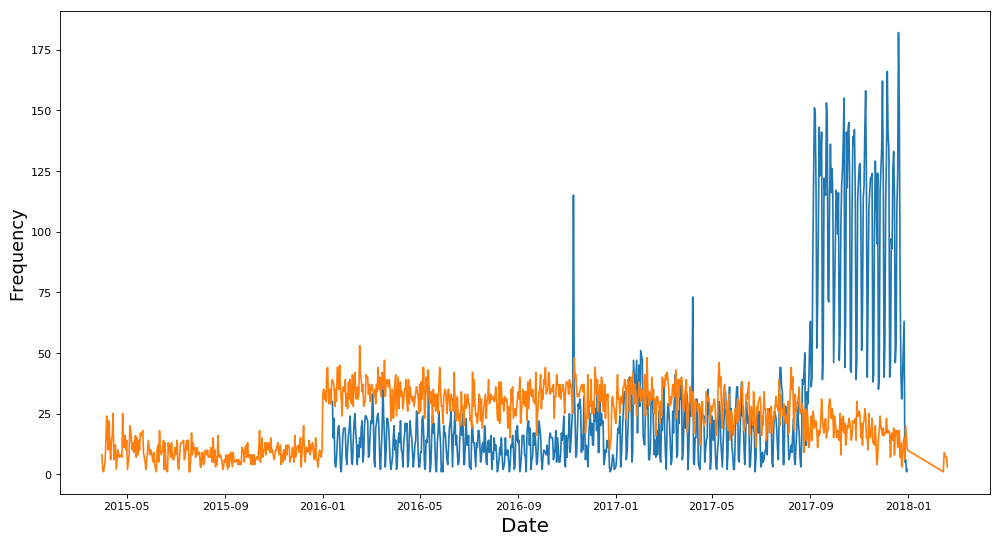

In [25]:
figure(figsize=(15, 8), dpi=80)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.plot(count_true_news_by_date)
plt.plot(count_fake_news_by_date)

In [26]:
#Let's concatenate text and title as title also might contain relevant info for our model
news['text_train'] = news['title'] + news['text']

##### **Now, before we dive into extracting information out of words in text and selected text,let's first clean the data**

In [27]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [28]:
news['text_train'] = news['text_train'].apply(lambda x:clean_text(x))

##### **Remove stop words**

In [29]:
stop = stopwords.words('english')
news['text_train'] = news['text_train'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

##### **Create cloud words the most common words in fake news and real news**

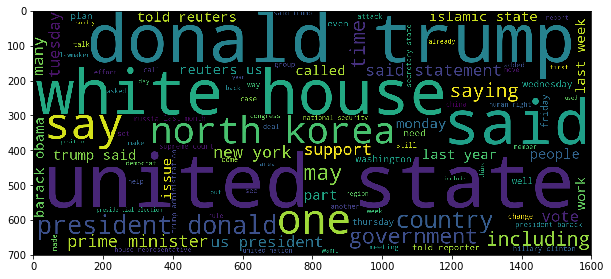

In [30]:
plt.figure(figsize=(10,10))
wc=WordCloud(max_words=100, width=1600, height=700, stopwords=STOPWORDS).generate("".join(news[news.Is_Fake==0].text_train))
plt.imshow(wc)

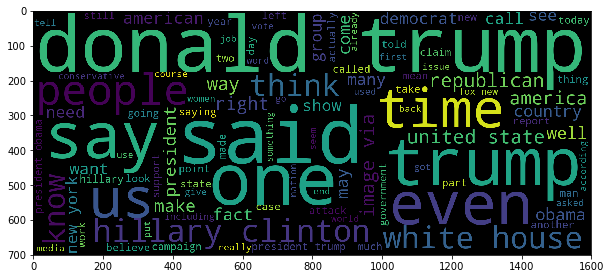

In [31]:
plt.figure(figsize=(10,10))
wc=WordCloud(max_words=100, width=1600, height=700, stopwords=STOPWORDS).generate("".join(news[news.Is_Fake==1].text_train))
plt.imshow(wc)

##### **Number of characters in text**

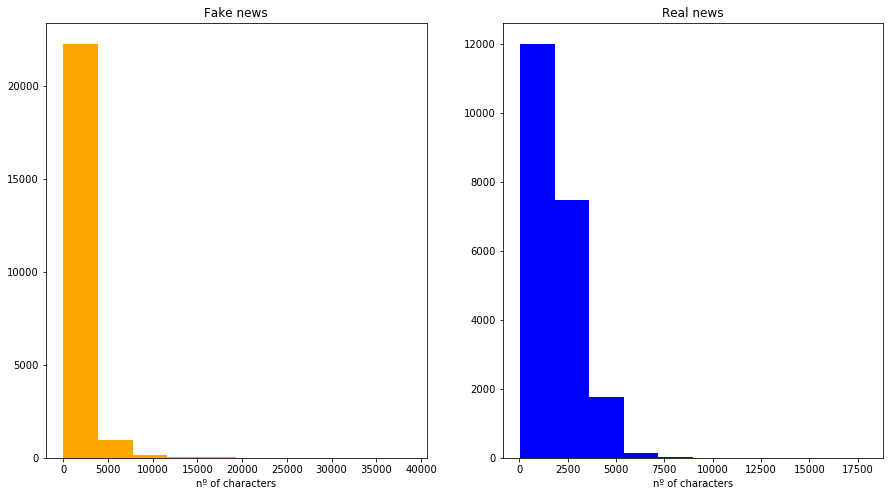

In [32]:
len_text_fake = news[news['Is_Fake']==1]['text_train'].str.len()
len_text_real = news[news['Is_Fake']==0]['text_train'].str.len()

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8)) # two axes on figure

ax1.hist(len_text_fake,color='orange')
ax1.set_title("Fake news")
ax1.set_xlabel("nº of characters")

ax2.hist(len_text_real,color='blue')
ax2.set_title("Real news")
ax2.set_xlabel("nº of characters")

plt.show()

##### **There are some differences in distribution of fake and real news. Fake news seems to be shorter in length compared to real ones**

##### **count of words**

In [33]:
fake_news = news[news['Is_Fake']==0]
real_news = news[news['Is_Fake']==1]

In [34]:
#Top20 for fake news
words_fake = pd.Series(' '.join(fake_news['text_train'].astype(str)).lower().split(" ")).value_counts()[:100]
words_fake[:20]

said          99032
trump         46557
us            44808
would         31648
reuters       26892
president     25596
state         19104
government    18187
house         17435
new           16748
states        16204
also          15946
republican    15896
united        15415
people        14692
told          14283
could         13877
last          12650
one           12396
two           11801
dtype: int64

In [35]:
#Top20 for real news
words_real = pd.Series(' '.join(real_news['text_train'].astype(str)).lower().split(" ")).value_counts()[:100]
words_real[:20]

trump        79774
said         31196
people       26281
president    26242
would        23647
one          23274
us           22903
obama        19326
clinton      18802
like         17925
donald       16789
also         15245
new          14951
hillary      14945
news         14778
even         13800
white        13463
time         12918
state        12825
media        11548
dtype: int64

##### **Here we can see TOP10 most popular words in the text field for fake and real news. The difference that we can spot already is that other figures are discussed in real news such as Hillary and Obama***

### Create ML models based on text field

In [36]:
#Shuffle rows for further data splitting
news = news.sample(frac=1).reset_index(drop=True)

In [37]:
X = news['text_train']
Y = news['Is_Fake']

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

##### **Naive Bayes**

In [39]:
pipeline_naive = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

pipeline_naive.fit(x_train, y_train)
y_pred_naive = pipeline_naive.predict(x_test)

###Save requested results

acc_naive = accuracy_score(y_test, y_pred_naive)
F1_naive = f1_score(y_test, y_pred_naive)

In [40]:
print(classification_report(y_test,y_pred_naive))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4344
           1       0.94      0.94      0.94      4634

    accuracy                           0.94      8978
   macro avg       0.94      0.94      0.94      8978
weighted avg       0.94      0.94      0.94      8978



##### **Logistic Regression**

In [41]:
pipeline_logistic = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

pipeline_logistic.fit(x_train, y_train)
y_pred_logistic = pipeline_logistic.predict(x_test)

###Save requested results

acc_logistic = accuracy_score(y_test, y_pred_logistic)
F1_logistic = f1_score(y_test, y_pred_logistic)

In [42]:
print(classification_report(y_test,y_pred_logistic))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4344
           1       0.99      0.98      0.99      4634

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



##### **Gradient Boosting**

In [43]:
pipeline_logistic = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', XGBClassifier())
])

pipeline_logistic.fit(x_train, y_train)
y_pred_boost = pipeline_logistic.predict(x_test)

###Save requested results

acc_boost = accuracy_score(y_test, y_pred_boost)
F1_boost = f1_score(y_test, y_pred_boost)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
print(classification_report(y_test,y_pred_boost))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4344
           1       0.99      1.00      0.99      4634

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



##### **Accuracy and F1 score of 3 models as requested**

In [45]:
models = {'model_name': ['Naive Bayes', 'Logistic Regression', 'Support Vector Classifer'],
          'accuracy': [acc_naive, acc_logistic, acc_boost],
          'f1_score': [F1_naive, F1_logistic, F1_boost]
}
models_df = pd.DataFrame(models)
models_df

,model_name,accuracy,f1_score
0,Naive Bayes,0.938962,0.940872
1,Logistic Regression,0.984629,0.985058
2,Support Vector Classifer,0.993206,0.993430


### **Build model with only one feature**

##### **As we see, all models are perfroming very well as all of them got accuracy and f1 score higher than 94%. In this section, I will build Logistic Regression, which uses only one feature - if the word 'reuters' is present in text or not. I chose this word because while analyzing the top words of fake and real data, the word "reuters" was one of the most frequent in the text data but was not present in TOP20 of real data.**

##### **Top20 below**

In [46]:
type(words_fake)

pandas.core.series.Series

In [47]:
words_fake[:20]

said          99032
trump         46557
us            44808
would         31648
reuters       26892
president     25596
state         19104
government    18187
house         17435
new           16748
states        16204
also          15946
republican    15896
united        15415
people        14692
told          14283
could         13877
last          12650
one           12396
two           11801
dtype: int64

In [48]:
words_real[:20]

trump        79774
said         31196
people       26281
president    26242
would        23647
one          23274
us           22903
obama        19326
clinton      18802
like         17925
donald       16789
also         15245
new          14951
hillary      14945
news         14778
even         13800
white        13463
time         12918
state        12825
media        11548
dtype: int64

In [49]:
#Create feature
news['reuters'] = news['text_train'].str.contains('reuters')

In [50]:
X = news['reuters'].values.reshape(-1,1)
Y = news['Is_Fake'].values.reshape(-1,1)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [52]:
clf = LogisticRegression()
fit = clf.fit(x_train, y_train)
y_pred_one_feat = fit.predict(x_test)

print(classification_report(y_test,y_pred_one_feat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4291
           1       1.00      0.99      0.99      4687

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


##### **As we can see, only with one feature we were able to build model with accuracy and F1 score of 99%.**

### Model selection summary

##### **In the notebook, I decided to train Naive Bayes, 2 Logistic Regression and Gradient Boosting classifiers.**

##### **First, all the algorithms, which were chosen are suitable for classification problem, which we are facing in this challenge.**

##### **Naive Bayes: According to my experience, this algorithm is easy to implement, fast and scalable. Also, it requires a small amount of training data and it's insensitive for irrelevant features. In this specific example, I used Multinomial Naive Bayes type as it's more suitable when dealing with discrete features (e.g., word counts) - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html**
##### **Also, we can use it with tf-idf, which I did in this case. However, it's important to mention that it has some limitations. The most critical one is Naive Bayes assumes that all features are independent, which normally is not true. That's why it's important to compare it with other models.**

##### **Logistic Regression: After applying Naive Bayes and being able to get accuracy and F1 score of 94% each, I was certain that there is no need to use deep learning techniques because it's easy to have a good model with very suitable data (which is the case). Logistic Regression is suitable for classification task and also, very simple algorith and easy to understand. It has important advantage over Naive Bayes - it does not assume that featurea are conditionally independent. Therefore, I chose Logistic Regression as a second algorithm. However, logistic regression also has some disadvantages - assumption of linearity beween features. Therefore, I used Decision Tree as a next step.**

##### **Gradient Boosting: GB is very flexible algotrith and it works well with categorical and numerical featrures. However, the most important factor is that GB is an ensemble learner. Therefore, it generates generate a final model based on a combination of individual models. This is the main advantage over the previous models.**

##### **The final model is the one with only one feature, which was developed previosuly. With such a simple model we were able to achieve accuracy and F1 score of 99%**